 # Modelling tests neural network

je teste ici des modèles de réseaux de neurones d'abord sur les signaux brutes
je ne détaille pas toutes les expériences faites.

Sur une base suréchantillonée de 13000 signaux par classe, les modèles ANN ne marchent pas très bien.
il y a trop de signaux normaux classés en anormaux.

De plus, il y a un décallage avec le train et le test. la loss sur le train continue de descendre alors que sur le test, on arrive à un plateau.
Il n'y a pas besoins de faire énormément d'itération pour arriver à ce plateau.
A partir de la le modèle s'overfit.

Par conséquent j'ai esssayé d'abord d'augementer la base avec 60000 signaux par classe et cela améliore nettement les résultats


j'ai testé plusieeurs types de modèles constituées de couches de réseaux de neurones. avec des hidden layers de mêmes nombre de neurones ou des hidden layers avec un nombre de neurones divisé par 2 à chaque couches. je fais aussi varier l'activation.

In [1]:
import os
import sys
sys.path.append('../src')
import time

from balance import load_balanced
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import joblib
from torch import optim
from sklearn.model_selection import train_test_split


## modèles

In [20]:
def modele_type_1_drop(n,activation=nn.Sigmoid,input_shape=187,device='cpu',dropout=0.2):
    model = nn.Sequential(
       nn.Linear(input_shape, n),
       activation(),
       nn.Dropout(dropout),
       nn.Linear(n, n),
       activation(),
       nn.Dropout(dropout),
       nn.Linear(n, n // 2),
       activation(),  
       nn.Linear(n // 2, 5)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
def modele_type_1_drop_norm(n,activation=nn.Sigmoid,input_shape=187,device='cpu',dropout=0.2):
    model = nn.Sequential(
       nn.Linear(input_shape, n),
       activation(),
       nn.BatchNorm1d(num_features=n),
       nn.Dropout(dropout),
       nn.Linear(n, n),
       activation(),
       nn.BatchNorm1d(num_features=n),
       nn.Dropout(dropout),
       nn.Linear(n, n // 2),
       activation(),  
       nn.Linear(n // 2, 5)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
def modele_type_1(n,activation=nn.Sigmoid,input_shape=187,device='cpu'):
    model = nn.Sequential(
       nn.Linear(input_shape, n),
       activation(),
       nn.Linear(n, n),
       activation(),
       nn.Linear(n, n // 2),
       activation(),  
       nn.Linear(n // 2, 5)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
def modele_type_2(n,activation=nn.Sigmoid,input_shape=187,device='cpu'):
    model = nn.Sequential(
       nn.Linear(input_shape, n),
       activation(),
       nn.Linear(n, n),
       activation(),
      
       nn.Linear(n, n),
       activation(),
       nn.Linear(n , 5)
    )   
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
def modele_type_2_drop(n,activation=nn.Sigmoid,input_shape=187,device='cpu',dropout=0.2):
    model = nn.Sequential(
       nn.Linear(input_shape, n),
       activation(),
       nn.Linear(n, n),
       activation(),
      
       nn.Linear(n, n),
        nn.Dropout(dropout),
       activation(),
       nn.Linear(n , 5)
    )   
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
def modele_type_3(n,p,activation=nn.Sigmoid,input_shape=187,device='cpu'):
    model = nn.Sequential()
    model.add_module("dense_start", nn.Linear(input_shape, n))
    model.add_module("act_start", activation())

    for couche in range(p):
        model.add_module("dense%d" %couche, nn.Linear(n, n))
        model.add_module("act%d" %couche, activation())
    model.add_module("dense_end", nn.Linear(n, 5))
    #model.add_module("act_start", nn.Sigmoid())
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model


## fonction d'entrainement et de test

j'utilise volontairement la précision 'macro' puisque la base de test est elle aussi totalement déséquilibrée. je voudrais que les anormaux ne soient pas classé en classe normal. 

si l'on prend la précision classique, j'ai des valeurs qui dépassent 90% alors que plus de la moitié des classe 1 est classée en 0
il faudra envisagé une sortie de l'entrainement si cette précision macro atteint une certaine valeur.

la précision marco du coup va minimiser l'impact d'avoir bien classé un grand nmbre de classe 0

il faudrait faire une base de cross - validation

In [3]:
def evaluate_model(model, test_set):
    X, y_true = test_set[:]
   
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # Calcul de la fonction de perte
    
    with torch.no_grad():
        # Prédiction du modèle pour un batch donné
        y_pred = model(X)

    loss_test = criterion(y_pred, y_true)
    
    y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
    y_true = y_true.numpy()
    accuracy = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred,average='macro')
    return y_true, y_pred, accuracy, recall, loss_test.item()
    
def train_a_model(model,train_loader,test_set,epochs = 100,lr=1e-3,device='cpu',outmodelname=None):

    best_accuracy = 0
    optimizer = optim.Adam(model.parameters(), lr)

    # Définition de la fonction de perte
    criterion = nn.CrossEntropyLoss()

    loss_list = []
    loss_list_test = []

    accuracy_list = []
    start = time.time()

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    mode='min',
                                                    factor=0.5,
                                                    patience=5,
                                                    verbose=True)

    for epoch in range(epochs):
        # Dans ce mode certaines couches du modèle agissent différemment
        model.train()
        loss_total = 0
        
        for batch in train_loader:
            # Batch de données
            X_batch, y_batch = batch
            
            # Device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Gradient mis 0
            model.zero_grad()
    
            # Calcul de prédiction
            y_pred = model(X_batch)
    
            # Calcul de la fonction de perte
            loss = criterion(y_pred, y_batch)
    
            # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
            loss.backward()
            
            # Clipper le gradient entre 0 et 1 pour plus de stabilité
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Descente de gradient : actualisation des paramètres
            optimizer.step()
            
            loss_total += loss.item()

        y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
        if accuracy > best_accuracy and outmodelname is not None:
            joblib.dump(model, outmodelname)
            print('save model')
            best_accuracy = accuracy
        loss_list.append(loss_total/len(train_loader))
        loss_list_test.append(loss)
        accuracy_list.append(accuracy)
        print(f"Epoch : {epoch+1}/{epochs} -- Training loss {loss_total/len(train_loader)}, --- Val loss {loss}, --- accuray : {accuracy}, --- recall : {recall}")

        scheduler.step(loss_total/len(train_loader))
        
    end = time.time()
    
    print("execution time: ",end - start)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(loss_list,label='loss train')
    ax.plot(loss_list_test,label='loss test')
    ax.legend()

    table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
    print(table)

    print(classification_report(y_true, y_pred))

base sur echantillonée: N signaux par classe=13000

calcul des features sur ces bases

## base de données à 50000 signaux par classe

In [4]:
#X_train,y_train = load_balanced.load_balanced_data(method='smote-perturb',n_normal=50000,smote_perturb_smote_ratio=0.5)
#pd.DataFrame(np.concatenate((X_train,np.expand_dims(y_train,axis=1)),axis=1)).to_csv('../data/processed/mitbih_train_smote_perturb_50000.csv',index=None,header=None)

df = pd.read_csv('../data/processed/features_mitbih_train_smote_perturb_50000.csv')
df.head()
y = np.array(df.pop('target'))
X = np.array(df)

X_train,X_cross, y_train, y_cross = train_test_split(X,y,test_size=0.1,random_state=12,shuffle=True)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled  = scaler.transform(X_train )
X_cross_scaled =  scaler.transform(X_cross )

df = pd.read_csv('../data/processed/features_mitbih_test.csv')
df.head()
y_valid = np.array(df.pop('target'))
X = np.array(df)

X_valid  = scaler.transform(X )


In [5]:
train_set = TensorDataset(torch.from_numpy(X_train_scaled).float(), torch.Tensor(torch.from_numpy(y_train).long()))
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
test_set = TensorDataset(torch.from_numpy(X_cross_scaled).float(), torch.Tensor(torch.from_numpy(y_cross).long()))
test_loader = DataLoader(test_set, batch_size=100, shuffle=True)

valid_set = TensorDataset(torch.from_numpy(X_valid).float(), torch.Tensor(torch.from_numpy(y_valid).long()))
valid_loader = DataLoader(valid_set, batch_size=100, shuffle=True)

In [6]:
N_epochs = 100

### modele 2

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            2,688
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,160
├─ReLU: 1-4                              --
├─Linear: 1-5                            4,160
├─ReLU: 1-6                              --
├─Linear: 1-7                            325
Total params: 11,333
Trainable params: 11,333
Non-trainable params: 0


C:\Users\carol\anaconda3\envs\heartbeat\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


save model
Epoch : 1/100 -- Training loss 0.2719677512711949, --- Val loss 0.15303969383239746, --- accuray : 0.9475608016852572, --- recall : 0.9477320023967277
save model
Epoch : 2/100 -- Training loss 0.13290247799952826, --- Val loss 0.12127422541379929, --- accuray : 0.9588642476212635, --- recall : 0.9587721628110399
save model
Epoch : 3/100 -- Training loss 0.10558763872873451, --- Val loss 0.09634345024824142, --- accuray : 0.9689212525757707, --- recall : 0.9689088980983538
Epoch : 4/100 -- Training loss 0.09040821631832255, --- Val loss 0.09882041066884995, --- accuray : 0.9664692890178023, --- recall : 0.966387838188267
save model
Epoch : 5/100 -- Training loss 0.08091794352212714, --- Val loss 0.08060169219970703, --- accuray : 0.9723369635173785, --- recall : 0.9723404351139717
save model
Epoch : 6/100 -- Training loss 0.07369280897101595, --- Val loss 0.07741803675889969, --- accuray : 0.9739364130118447, --- recall : 0.9738472250197473
save model
Epoch : 7/100 -- Trainin

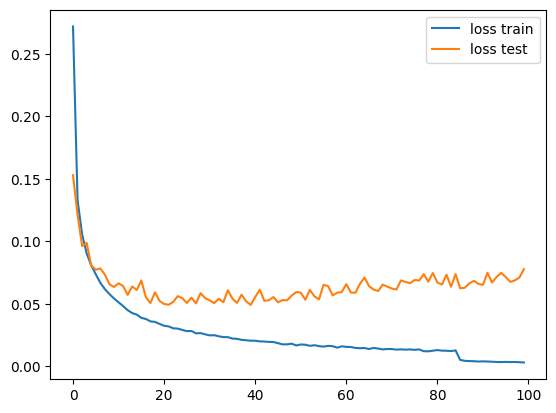

In [7]:
model = modele_type_2(64,input_shape=41,activation=nn.ReLU)
train_a_model(model,train_loader,test_set,epochs = N_epochs,lr=1e-3,outmodelname='../models/Ann_features_2_64.pkl')

In [8]:
model = joblib.load('../models/Ann_features_2_64.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, valid_set)


table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17736  213    79   44    46
1             90  454     8    3     1
2             35    8  1378   21     6
3             14    1    12  134     1
4             22    8     5    2  1571
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     18118
           1       0.66      0.82      0.73       556
           2       0.93      0.95      0.94      1448
           3       0.66      0.83      0.73       162
           4       0.97      0.98      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.84      0.91      0.87     21892
weighted avg       0.97      0.97      0.97     21892



Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            2,688
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,160
├─ReLU: 1-4                              --
├─Linear: 1-5                            4,160
├─Dropout: 1-6                           --
├─ReLU: 1-7                              --
├─Linear: 1-8                            325
Total params: 11,333
Trainable params: 11,333
Non-trainable params: 0


C:\Users\carol\anaconda3\envs\heartbeat\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


save model
Epoch : 1/100 -- Training loss 0.2859554756101635, --- Val loss 0.1615847796201706, --- accuray : 0.946147215095577, --- recall : 0.9447518294957089
save model
Epoch : 2/100 -- Training loss 0.14506431575119497, --- Val loss 0.11418357491493225, --- accuray : 0.9605688711161436, --- recall : 0.9605545793075587
save model
Epoch : 3/100 -- Training loss 0.11411135388414065, --- Val loss 0.1029403805732727, --- accuray : 0.9643631256381766, --- recall : 0.9643677381856899
save model
Epoch : 4/100 -- Training loss 0.09655107235701547, --- Val loss 0.09566851705312729, --- accuray : 0.969089966836794, --- recall : 0.9689611664392425
save model
Epoch : 5/100 -- Training loss 0.08602844096885787, --- Val loss 0.08028468489646912, --- accuray : 0.97342299684125, --- recall : 0.9734360696070965
save model
Epoch : 6/100 -- Training loss 0.07774386150617567, --- Val loss 0.07775557786226273, --- accuray : 0.975285663696044, --- recall : 0.9753425799844668
Epoch : 7/100 -- Training loss

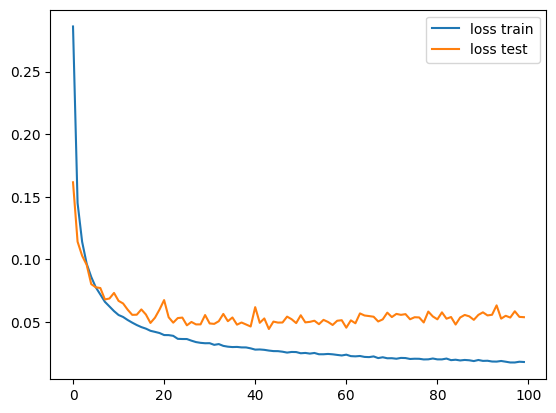

In [21]:
model = modele_type_2_drop(64,input_shape=41,activation=nn.ReLU)
train_a_model(model,train_loader,test_set,epochs = N_epochs,lr=1e-3,outmodelname='../models/Ann_features_2_64_drop.pkl')

In [22]:
model = joblib.load('../models/Ann_features_2_64_drop.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, valid_set)


table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17694  279    72   37    36
1             91  449    10    2     4
2             41    8  1370   20     9
3             12    2    18  129     1
4             24    5    10    2  1567
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     18118
           1       0.60      0.81      0.69       556
           2       0.93      0.95      0.94      1448
           3       0.68      0.80      0.73       162
           4       0.97      0.97      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.83      0.90      0.86     21892
weighted avg       0.97      0.97      0.97     21892



## modele 1

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            2,688
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,160
├─ReLU: 1-4                              --
├─Linear: 1-5                            2,080
├─ReLU: 1-6                              --
├─Linear: 1-7                            165
Total params: 9,093
Trainable params: 9,093
Non-trainable params: 0


C:\Users\carol\anaconda3\envs\heartbeat\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


save model
Epoch : 1/100 -- Training loss 0.2776757930732436, --- Val loss 0.16791865229606628, --- accuray : 0.9422464233815848, --- recall : 0.9420862538025918
save model
Epoch : 2/100 -- Training loss 0.13961496775680118, --- Val loss 0.11791954189538956, --- accuray : 0.960016914959661, --- recall : 0.9597782239648842
save model
Epoch : 3/100 -- Training loss 0.11144497166780962, --- Val loss 0.11151323467493057, --- accuray : 0.961730824149355, --- recall : 0.9611301688719582
save model
Epoch : 4/100 -- Training loss 0.09537073179789715, --- Val loss 0.09181196242570877, --- accuray : 0.9701875690636855, --- recall : 0.9701559970696749
save model
Epoch : 5/100 -- Training loss 0.0848233353814317, --- Val loss 0.08823857456445694, --- accuray : 0.9702737498226345, --- recall : 0.9700945444823346
save model
Epoch : 6/100 -- Training loss 0.07729420436608295, --- Val loss 0.08461247384548187, --- accuray : 0.9719265721010817, --- recall : 0.9718127199345371
save model
Epoch : 7/100 -

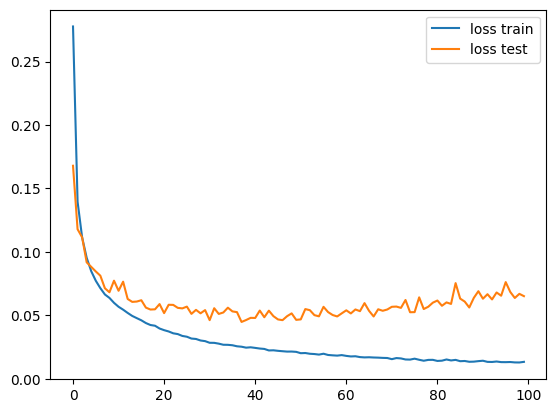

In [9]:
model = modele_type_1(64,input_shape=41,activation=nn.ReLU)
train_a_model(model,train_loader,test_set,epochs = N_epochs,lr=1e-3,outmodelname='../models/Ann_features_1_64_relu.pkl')

In [10]:
model = joblib.load('../models/Ann_features_1_64_relu.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, valid_set)


table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17596  297   107   50    68
1             72  469    11    2     2
2             30    7  1385   21     5
3              9    2    14  137     0
4              9    5    14    1  1579
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18118
           1       0.60      0.84      0.70       556
           2       0.90      0.96      0.93      1448
           3       0.65      0.85      0.73       162
           4       0.95      0.98      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.82      0.92      0.86     21892
weighted avg       0.97      0.97      0.97     21892



Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            2,688
├─Sigmoid: 1-2                           --
├─Linear: 1-3                            4,160
├─Sigmoid: 1-4                           --
├─Linear: 1-5                            2,080
├─Sigmoid: 1-6                           --
├─Linear: 1-7                            165
Total params: 9,093
Trainable params: 9,093
Non-trainable params: 0


C:\Users\carol\anaconda3\envs\heartbeat\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


save model
Epoch : 1/100 -- Training loss 0.6435753474500444, --- Val loss 0.35600149631500244, --- accuray : 0.8861425238195327, --- recall : 0.8831014630550836
save model
Epoch : 2/100 -- Training loss 0.2845061839355363, --- Val loss 0.23502835631370544, --- accuray : 0.9213201829768669, --- recall : 0.9212546405360097
save model
Epoch : 3/100 -- Training loss 0.20796632311575944, --- Val loss 0.1878873109817505, --- accuray : 0.9347240064556553, --- recall : 0.9342541501999074
save model
Epoch : 4/100 -- Training loss 0.17326194561521213, --- Val loss 0.16404157876968384, --- accuray : 0.9449643019891637, --- recall : 0.945004205557125
save model
Epoch : 5/100 -- Training loss 0.15313445911473697, --- Val loss 0.14242461323738098, --- accuray : 0.9525341526761597, --- recall : 0.9527283651419655
save model
Epoch : 6/100 -- Training loss 0.13842903911074003, --- Val loss 0.13292710483074188, --- accuray : 0.9557083709971458, --- recall : 0.9557617082880536
save model
Epoch : 7/100 -

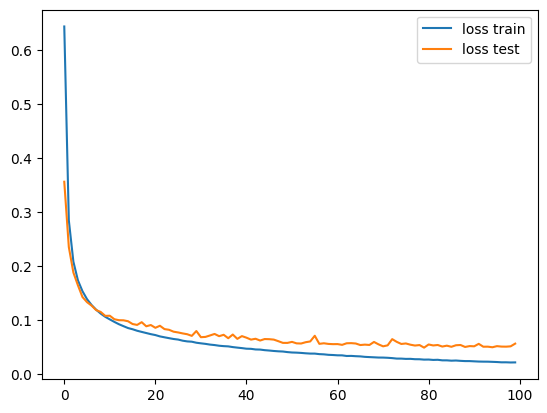

In [11]:
model = modele_type_1(64,input_shape=41,activation=nn.Sigmoid)
train_a_model(model,train_loader,test_set,epochs = N_epochs,lr=1e-3,outmodelname='../models/Ann_features_1_64_sigmoid.pkl')


In [12]:
model = joblib.load('../models/Ann_features_1_64_sigmoid.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, valid_set)


table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17564  291   160   45    58
1             81  458    11    3     3
2             29    5  1383   26     5
3             15    1    15  131     0
4             12    4     9    3  1580
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18118
           1       0.60      0.82      0.70       556
           2       0.88      0.96      0.91      1448
           3       0.63      0.81      0.71       162
           4       0.96      0.98      0.97      1608

    accuracy                           0.96     21892
   macro avg       0.81      0.91      0.85     21892
weighted avg       0.97      0.96      0.97     21892



Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            2,688
├─LeakyReLU: 1-2                         --
├─Linear: 1-3                            4,160
├─LeakyReLU: 1-4                         --
├─Linear: 1-5                            2,080
├─LeakyReLU: 1-6                         --
├─Linear: 1-7                            165
Total params: 9,093
Trainable params: 9,093
Non-trainable params: 0


C:\Users\carol\anaconda3\envs\heartbeat\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


save model
Epoch : 1/100 -- Training loss 0.2897658991747432, --- Val loss 0.16499146819114685, --- accuray : 0.9445498822205198, --- recall : 0.9443897799292242
save model
Epoch : 2/100 -- Training loss 0.14585671209378376, --- Val loss 0.12301599979400635, --- accuray : 0.958220574815663, --- recall : 0.9583601728551034
save model
Epoch : 3/100 -- Training loss 0.11360643654730584, --- Val loss 0.10341550409793854, --- accuray : 0.9669256369142406, --- recall : 0.9666051821578943
save model
Epoch : 4/100 -- Training loss 0.09603762095711298, --- Val loss 0.09795515984296799, --- accuray : 0.9679088880881576, --- recall : 0.9678880069255055
save model
Epoch : 5/100 -- Training loss 0.0850761720120079, --- Val loss 0.08795928955078125, --- accuray : 0.9706855544104244, --- recall : 0.9706696476057763
save model
Epoch : 6/100 -- Training loss 0.07772287678159773, --- Val loss 0.08706147223711014, --- accuray : 0.9716688016676975, --- recall : 0.9715188668968482
save model
Epoch : 7/100 

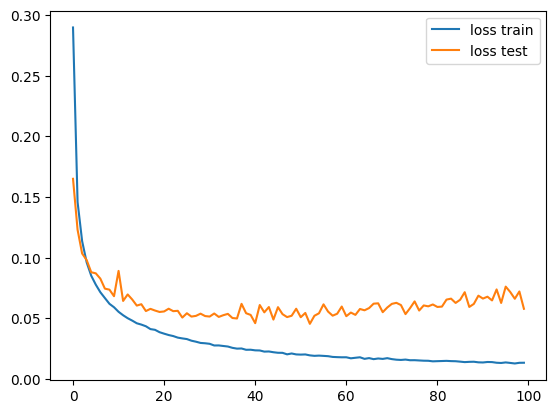

In [13]:
model = modele_type_1(64,input_shape=41,activation=nn.LeakyReLU)
train_a_model(model,train_loader,test_set,epochs = N_epochs,lr=1e-3,outmodelname='../models/Ann_features_1_64_leaky.pkl')

test

In [14]:
model = joblib.load('../models/Ann_features_1_64_leaky.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, valid_set)


table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17703  268    76   32    39
1             81  460    10    2     3
2             42    8  1369   20     9
3             22    2    12  126     0
4             19    7    13    2  1567
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     18118
           1       0.62      0.83      0.71       556
           2       0.93      0.95      0.94      1448
           3       0.69      0.78      0.73       162
           4       0.97      0.97      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.84      0.90      0.87     21892
weighted avg       0.97      0.97      0.97     21892



Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            2,688
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            4,160
├─ReLU: 1-5                              --
├─Dropout: 1-6                           --
├─Linear: 1-7                            2,080
├─ReLU: 1-8                              --
├─Linear: 1-9                            165
Total params: 9,093
Trainable params: 9,093
Non-trainable params: 0


C:\Users\carol\anaconda3\envs\heartbeat\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


save model
Epoch : 1/200 -- Training loss 0.39271766217218507, --- Val loss 0.20557183027267456, --- accuray : 0.9267768172929927, --- recall : 0.9265922519677152
save model
Epoch : 2/200 -- Training loss 0.24019008915291892, --- Val loss 0.16404633224010468, --- accuray : 0.9440676550192333, --- recall : 0.9440118652736251
save model
Epoch : 3/200 -- Training loss 0.20906739702820779, --- Val loss 0.14129841327667236, --- accuray : 0.9508742228147007, --- recall : 0.9510377897828921
save model
Epoch : 4/200 -- Training loss 0.19054199245075384, --- Val loss 0.12843866646289825, --- accuray : 0.9567795831570646, --- recall : 0.9566656256058821
save model
Epoch : 5/200 -- Training loss 0.17859346013930108, --- Val loss 0.11889911442995071, --- accuray : 0.9589504878348254, --- recall : 0.9585266546268499
save model
Epoch : 6/200 -- Training loss 0.17032027627362145, --- Val loss 0.11227957904338837, --- accuray : 0.9616037326166567, --- recall : 0.9616389022076067
save model
Epoch : 7/2

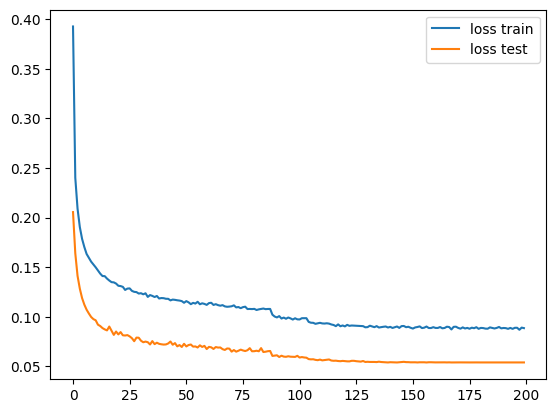

In [15]:
model = modele_type_1_drop(64,input_shape=41,activation=nn.ReLU)
train_a_model(model,train_loader,test_set,epochs = N_epochs*2,lr=1e-3,outmodelname='../models/Ann_features_1_64_relu_drop.pkl')

In [16]:
model = joblib.load('../models/Ann_features_1_64_relu_drop.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, valid_set)


table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17432  444   116   72    54
1             68  472    13    1     2
2             28    7  1380   26     7
3             12    2    11  137     0
4             17    3    10    2  1576
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     18118
           1       0.51      0.85      0.64       556
           2       0.90      0.95      0.93      1448
           3       0.58      0.85      0.69       162
           4       0.96      0.98      0.97      1608

    accuracy                           0.96     21892
   macro avg       0.79      0.92      0.84     21892
weighted avg       0.97      0.96      0.96     21892



Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            2,688
├─ReLU: 1-2                              --
├─BatchNorm1d: 1-3                       128
├─Dropout: 1-4                           --
├─Linear: 1-5                            4,160
├─ReLU: 1-6                              --
├─BatchNorm1d: 1-7                       128
├─Dropout: 1-8                           --
├─Linear: 1-9                            2,080
├─ReLU: 1-10                             --
├─Linear: 1-11                           165
Total params: 9,349
Trainable params: 9,349
Non-trainable params: 0


C:\Users\carol\anaconda3\envs\heartbeat\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


save model
Epoch : 1/200 -- Training loss 0.33514073697063657, --- Val loss 0.173061341047287, --- accuray : 0.9385964839360049, --- recall : 0.9385166409487024
save model
Epoch : 2/200 -- Training loss 0.2192018840180503, --- Val loss 0.13454008102416992, --- accuray : 0.952771833050688, --- recall : 0.9525914061636748
save model
Epoch : 3/200 -- Training loss 0.19508171122438378, --- Val loss 0.11845029145479202, --- accuray : 0.9585872007068339, --- recall : 0.9586402081879133
save model
Epoch : 4/200 -- Training loss 0.1812298691769441, --- Val loss 0.11181386560201645, --- accuray : 0.960609377719495, --- recall : 0.9607233470874966
save model
Epoch : 5/200 -- Training loss 0.17174842944410112, --- Val loss 0.10372433811426163, --- accuray : 0.9623248091006811, --- recall : 0.9623100102034343
save model
Epoch : 6/200 -- Training loss 0.16355009175009197, --- Val loss 0.09993300586938858, --- accuray : 0.964387417531127, --- recall : 0.9643914446047581
save model
Epoch : 7/200 -- T

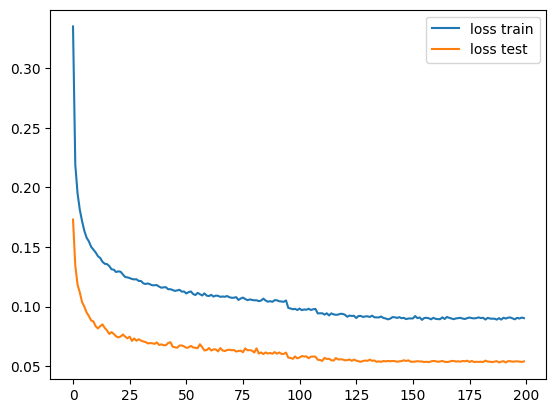

In [17]:
model = modele_type_1_drop_norm(64,input_shape=41,activation=nn.ReLU)
train_a_model(model,train_loader,test_set,epochs = N_epochs*2,lr=1e-3,outmodelname='../models/Ann_features_1_64_relu_drop_norm.pkl')

In [18]:
model = joblib.load('../models/Ann_features_1_64_relu_drop_norm.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, valid_set)


table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17416  406   131   92    73
1             65  471    16    2     2
2             28    3  1384   24     9
3              8    1    10  143     0
4             13    5     6    1  1583
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     18118
           1       0.53      0.85      0.65       556
           2       0.89      0.96      0.92      1448
           3       0.55      0.88      0.67       162
           4       0.95      0.98      0.97      1608

    accuracy                           0.96     21892
   macro avg       0.78      0.93      0.84     21892
weighted avg       0.97      0.96      0.96     21892

